CS166 Pre-class work 12.2
# Metropolis Hastings
#### April 2, 2020 | Rebecca Mqamelo 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def f(x):
    Z = 24.44321494051954
    if abs(x) > 7:
        return 0
    elif abs(x) > 3:
        return 3 * (1 - (x / 7) ** 2) ** 0.5 / Z
    elif abs(x) > 1:
        return ((3 - abs(x)) / 2 - 3/7 * 10**0.5 * ((3 - x**2 + 2*abs(x))**0.5 - 2)) / Z
    elif abs(x) > 0.75:
        return (9 - 8 * abs(x)) / Z
    elif abs(x) > 0.5:
        return (3 * abs(x) + 0.75) / Z
    else:
        return 2.25 / Z

In [4]:
# Define normal distribution with standard deviation=2
def g(x):
    return np.random.normal(x,2)

In [8]:
class MH():
    
    def __init__(self,f,g):
        self.f = f
        self.g = g
        self.reset()
        
    def reset(self):
        # initialize from 0, avoid initializing to f(x)=0
        self.state = self.g(0)
        if self.f(self.state) == 0:
            self.reset()
        self.record = []
        
    def step(self):
        proposed = self.g(self.state)
        decision = min(1,self.f(proposed)/self.f(self.state))
        if np.random.uniform(0,1) < decision:
            self.state = proposed
            
    def observe(self,binsratio=10,xmin=-8,xmax=8):
        plt.figure(figsize=(16,7))
        plt.hist(self.record,bins=len(self.record)//binsratio, density=True, color="black")
        xs = np.linspace(xmin, xmax, 1000)
        plt.show()
    
    def simulate(self,steps=100000,record=100):
        self.reset()
        for i in range(steps):
            self.step()
            if record and i%record==0:
                self.record.append(self.state)
                
    def draw(self,steps=100000):
        self.simulate(steps=steps,record=None)
        return self.state

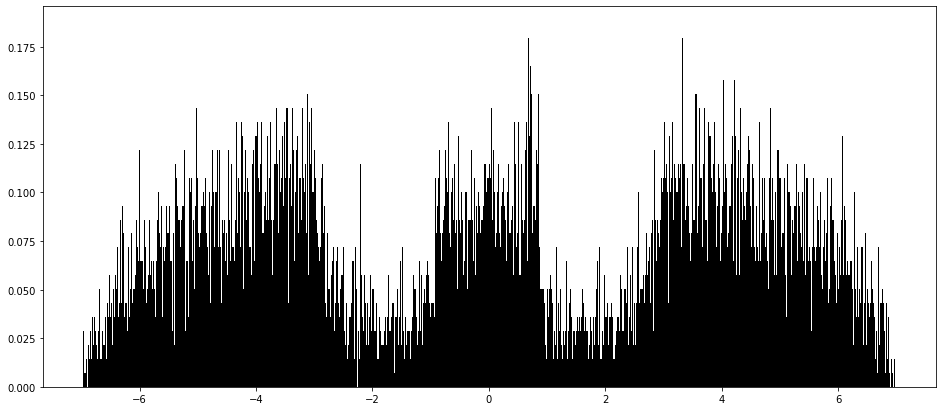

In [9]:
sim = MH(f,g)
sim.simulate(100000,record=10)
sim.observe()

Notes

In [5]:
def sampler(data, samples=4, mu_init=.5, proposal_width=2, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()